In [1]:
import pandas as pd
import numpy as np
#Packages below are required only for visualization
import matplotlib.pyplot as plt
from scipy import stats

### Rergression estimator of the target class area for stratified random sampling, from Tyukavina et al. (in review) "Options for global sampling of geographic data"

#### Example of input data

In [2]:
#Read strata info table with columns:
#"Stratum" - stratum ID, 1 - nstrata;
#"Area_km2" - stratum area in km2 or any other area units, needs to be consistend with pixel size area units in data table;
#"Count" - total number of units (pixels, polygons) in each stratum
#"Xh" - stratum-specific mean of the proportion (from 0 to 1) of auxiliary class (calculated accross all units in the stratum)
strata = pd.read_csv('5.3.strata_info.txt', sep = '\t')

In [49]:
strata.head().style.hide_index()

Stratum,Area_km2,Count,Xh
1,331763.613000,13314,0.000000
2,368042.987900,14767,0.003979
3,88783.438150,3563,0.044713


In [3]:
#Read sample interpretation table with columns:
#"Stratum" - stratum ID, 1 - nstrata;
#"yi" - proportion (from 0 to 1) of the target class from the area of the sampled unit (derived from sample interpretation);
#"xi" - proportion (from 0 to 1) of the auxiliary class from the area of the sampled unit (derived from a wall-to-wall map);

data = pd.read_csv('5.3.Sample_data.txt', sep ='\t')

#Merge data table with sample info table
data = data.merge(strata)
data = data.rename(columns = {'Area_km2':'Ah', 'Count':'Nh'})

In [4]:
data.head().style.hide_index()

Stratum,xi,yi,Ah,Nh,Xh
3,0.035278,0.040241,88783.438150,3563,0.044713
3,0.040433,0.042939,88783.438150,3563,0.044713
3,0.029619,0.018025,88783.438150,3563,0.044713
3,0.049816,0.042608,88783.438150,3563,0.044713
3,0.022867,0.022676,88783.438150,3563,0.044713


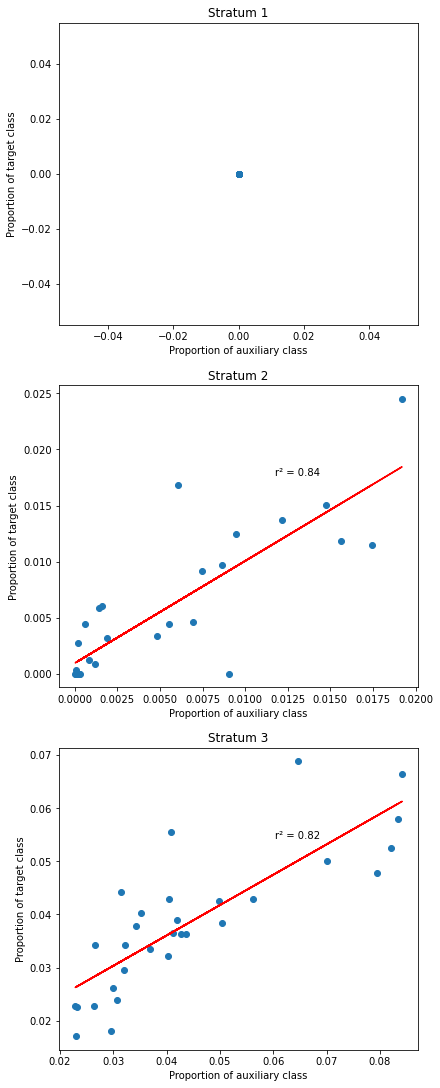

In [5]:
#Visualize linear regression between y and x in each stratum

fig, axes = plt.subplots(3,figsize=(6,15), constrained_layout=True)
nstrata = data.Stratum.max()

for stratum in range(nstrata):
    datasubs = data[data['Stratum']==stratum+1]
    axes[stratum].scatter(datasubs.xi,datasubs.yi)
    axes[stratum].set_xlabel('Proportion of auxiliary class')
    axes[stratum].set_ylabel('Proportion of target class')
    axes[stratum].set_title(f'Stratum {stratum+1}')

    if datasubs.yi.max()>0 and datasubs.xi.max()>0:
        linreg = stats.linregress(datasubs.xi, datasubs.yi)
        axes[stratum].plot(datasubs.xi, linreg.intercept + linreg.slope*datasubs.xi, 'r')
        axes[stratum].text(0.6,0.7, 'r² = %0.2f' % linreg.rvalue, transform=axes[stratum].transAxes)
    
plt.show()

#### Functions to produce regression estimate of target class area and its standard error, strata weighted by number of units

In [6]:
def estimate_area_reg_Nh(df: pd.DataFrame) -> float:
    """ 
    Function to produce regression estimator of target class area from sample refernce values 
    for sampling of units (pixels/polygons) with equal area, stratified random sampling.
    Strata weighted by their respective unit counts (Nh).
    ~~~
    Input dataframe with number of lines equal the number of sample pixels/polygons,
    and the following columns:
    "Stratum" (strata IDs 1 - nstrata)
    "yi" (proportion (from 0 to 1) of the target class from the area of the sampled unit (derived from sample interpretation);
    "xi" (proportion (from 0 to 1) of the auxiliary class from the area of the sampled unit (derived from a wall-to-wall map);
    "Ah" (stratum area, km²<or any other area unit>)
    "Nh" (number of units in each stratum h)
    "Xh" (mean of the proportion (from 0 to 1) of auxiliary class,calculated accross all units in stratum h)
    ~~~
    Returns estimated target class area in units of Ah
    ~~~
    From Tyukavina et al. (in review) "Options for global sampling of geographic data"
    Appendix, equations 41-43, 38
    """
    #Compute per-stratum means of yi and xi
    ymean = df.groupby(by = ['Stratum']).yi.mean().reset_index().rename(columns = {'yi':'ymean'})
    df1 = df.merge(ymean)
    xmean = df.groupby(by = ['Stratum']).xi.mean().reset_index().rename(columns = {'xi':'xmean'})
    df1 = df1.merge(xmean)
    
    df1['y-ymean'] = df1['yi'] - df1['ymean']
    df1['x-xmean'] = df1['xi'] - df1['xmean']
    df1['(x-xmean)(y-ymean)'] = df1['y-ymean'] * df1['x-xmean']
    df1['(x-xmean)^2'] = df1['x-xmean'] * df1['x-xmean']
    
    #Group by stratum
    ByStratum = df1.groupby(by = ['Stratum'])
    
    #Equation 43
    bh = (ByStratum['(x-xmean)(y-ymean)']).sum() / (ByStratum['(x-xmean)^2']).sum()
    
    #Equation 42
    Xh = ByStratum['Xh'].median()
    Yh = ByStratum['yi'].mean() + bh * (Xh - ByStratum['xi'].mean())
    
    #Equation 41
    Nh = ByStratum['Nh'].median()
    N = Nh.sum()
    Yest = (Nh * Yh / N).sum()
    
    # Equation 38
    Atot = (ByStratum['Ah'].median()).sum()
    area = Yest * Atot

    return area

In [7]:
estimate_area_reg_Nh(data)

5120.879455513931

In [8]:
def estimate_area_SE_reg_Nh(df: pd.DataFrame) -> float:
    """ 
    Function to estimate SE of the regression estimate of target class area from sample refernce values 
    for sampling of units (pixels/polygons) with equal area, stratified random sampling.
    Strata weighted by their respective unit counts (Nh).
    ~~~
    Input dataframe with number of lines equal the number of sample pixels/polygons,
    and the following columns:
    "Stratum" (strata IDs 1 - nstrata)
    "yi" (proportion (from 0 to 1) of the target class from the area of the sampled unit (derived from sample interpretation);
    "xi" (proportion (from 0 to 1) of the auxiliary class from the area of the sampled unit (derived from a wall-to-wall map);
    "Ah" (stratum area, km²<or any other area unit>)
    "Nh" (number of units in each stratum h)
    ~~~
    Returns estimated standard error of target class area in units of Ah 
    ~~~
    From Tyukavina et al. (in review) "Options for global sampling of geographic data"
    Appendix, equations 40, 43 and 46
    """
    #Compute per-stratum means of yi and xi
    ymean = df.groupby(by = ['Stratum']).yi.mean().reset_index().rename(columns = {'yi':'ymean'})
    df1 = df.merge(ymean)
    xmean = df.groupby(by = ['Stratum']).xi.mean().reset_index().rename(columns = {'xi':'xmean'})
    df1 = df1.merge(xmean)
    
    df1['y-ymean'] = df1['yi'] - df1['ymean']
    df1['x-xmean'] = df1['xi'] - df1['xmean']
    df1['(y-ymean)^2'] = df1['y-ymean'] * df1['y-ymean']
    df1['(x-xmean)^2'] = df1['x-xmean'] * df1['x-xmean']
    df1['(x-xmean)(y-ymean)'] = df1['y-ymean'] * df1['x-xmean']
    
    #Group by stratum
    ByStratum = df1.groupby(by = ['Stratum'])
    
    #Equation 43
    bh = (ByStratum['(x-xmean)(y-ymean)']).sum() / (ByStratum['(x-xmean)^2']).sum()
    
    #Equation 46
    Nh = ByStratum['Nh'].median()
    N = Nh.sum()
    nh = ByStratum['yi'].count()
    ForVar = (ByStratum['(y-ymean)^2']).sum() - bh * bh * (ByStratum['(x-xmean)^2']).sum()
    Var = ForVar * Nh * Nh * (1 - nh/Nh) / (nh * (nh - 2)) 
    SumVar = Var.sum() / N / N
 
    # Equation 40
    Atot = (ByStratum['Ah'].median()).sum()
    SE = np.sqrt(SumVar) * Atot

    return SE

In [9]:
estimate_area_SE_reg_Nh(data)

267.27154793958357

#### Functions to produce regression estimate of target class area and its standard error, strata weighted by area

In [10]:
def estimate_area_reg_Ah(df: pd.DataFrame) -> float:
    """ 
    Function to produce regression estimator of target class area from sample refernce values 
    for sampling of units (pixels/polygons) with equal area, stratified random sampling.
    Strata weighted by their respective areas (Ah).
    ~~~
    Input dataframe with number of lines equal the number of sample pixels/polygons,
    and the following columns:
    "Stratum" (strata IDs 1 - nstrata)
    "yi" (proportion (from 0 to 1) of the target class from the area of the sampled unit (derived from sample interpretation);
    "xi" (proportion (from 0 to 1) of the auxiliary class from the area of the sampled unit (derived from a wall-to-wall map);
    "Ah" (stratum area, km²<or any other area unit>)
    "Xh" (mean of the proportion (from 0 to 1) of auxiliary class,calculated accross all units in stratum h)
    ~~~
    Returns estimated target class area in units of Ah
    ~~~
    From Tyukavina et al. (in review) "Options for global sampling of geographic data"
    Appendix, equations 42, 43 and 45
    """
    #Compute per-stratum means of yi and xi
    ymean = df.groupby(by = ['Stratum']).yi.mean().reset_index().rename(columns = {'yi':'ymean'})
    df1 = df.merge(ymean)
    xmean = df.groupby(by = ['Stratum']).xi.mean().reset_index().rename(columns = {'xi':'xmean'})
    df1 = df1.merge(xmean)
    
    df1['y-ymean'] = df1['yi'] - df1['ymean']
    df1['x-xmean'] = df1['xi'] - df1['xmean']
    df1['(x-xmean)(y-ymean)'] = df1['y-ymean'] * df1['x-xmean']
    df1['(x-xmean)^2'] = df1['x-xmean'] * df1['x-xmean']
    
    #Group by stratum
    ByStratum = df1.groupby(by = ['Stratum'])
    
    #Equation 43
    bh = (ByStratum['(x-xmean)(y-ymean)']).sum() / (ByStratum['(x-xmean)^2']).sum()
    
    #Equation 42
    Xh = ByStratum['Xh'].median()
    Yh = ByStratum['yi'].mean() + bh * (Xh - ByStratum['xi'].mean())
    
    #Equation 45
    Ah = ByStratum['Ah'].median()
    area = (Yh * Ah).sum()

    return area

In [11]:
estimate_area_reg_Ah(data)

5120.71214582562

In [12]:
def estimate_area_SE_reg_Ah(df: pd.DataFrame) -> float:
    """ 
    Function to estimate SE of the regression estimate of target class area from sample refernce values 
    for sampling of units (pixels/polygons) with equal area, stratified random sampling.
    Strata weighted by their respective areas (Ah).
    ~~~
    Input dataframe with number of lines equal the number of sample pixels/polygons,
    and the following columns:
    "Stratum" (strata IDs 1 - nstrata)
    "yi" (proportion (from 0 to 1) of the target class from the area of the sampled unit (derived from sample interpretation);
    "xi" (proportion (from 0 to 1) of the auxiliary class from the area of the sampled unit (derived from a wall-to-wall map);
    "Ah" (stratum area, km²<or any other area unit>)
    "Nh" (number of units in each stratum h)
    ~~~
    Returns estimated standard error of target class area in units of Ah 
    ~~~
    From Tyukavina et al. (in review) "Options for global sampling of geographic data"
    Appendix, equations 40, 43 and 46
    """
    #Compute per-stratum means of yi and xi
    ymean = df.groupby(by = ['Stratum']).yi.mean().reset_index().rename(columns = {'yi':'ymean'})
    df1 = df.merge(ymean)
    xmean = df.groupby(by = ['Stratum']).xi.mean().reset_index().rename(columns = {'xi':'xmean'})
    df1 = df1.merge(xmean)
    
    df1['y-ymean'] = df1['yi'] - df1['ymean']
    df1['x-xmean'] = df1['xi'] - df1['xmean']
    df1['(y-ymean)^2'] = df1['y-ymean'] * df1['y-ymean']
    df1['(x-xmean)^2'] = df1['x-xmean'] * df1['x-xmean']
    df1['(x-xmean)(y-ymean)'] = df1['y-ymean'] * df1['x-xmean']
    
    #Group by stratum
    ByStratum = df1.groupby(by = ['Stratum'])
    
    #Equation 43
    bh = (ByStratum['(x-xmean)(y-ymean)']).sum() / (ByStratum['(x-xmean)^2']).sum()
    
    #Equations 47, modified to estimate variance of the area estimate by eliminating division by Atot^2
    Nh = ByStratum['Nh'].median()
    Ah = ByStratum['Ah'].median()
    N = Nh.sum()
    nh = ByStratum['yi'].count()
    ForVar = (ByStratum['(y-ymean)^2']).sum() - bh * bh * (ByStratum['(x-xmean)^2']).sum()
    Var = ForVar * Ah * Ah * (1 - nh/Nh) / (nh * (nh - 2)) 
    SumVar = Var.sum()
 
    # Equation 40 without multiplication by Atot, since variance is already in squared area units from previous step
    SE = np.sqrt(SumVar)

    return SE

In [13]:
estimate_area_SE_reg_Ah(data)

267.28810995893843